# Exploratory data analysis on Imbruvica data

For each prescriber and drug, the dataset includes the total number of prescriptions that were dispensed (including original prescriptions and any refills), total 30-day standardized fill counts, total day’s supply for these prescriptions, and the total drug cost. To protect the privacy of Medicare beneficiaries, any aggregated records which are derived from 10 or fewer claims are excluded from the Part D Prescriber PUF.


bene_count_ge65 – The total number of unique Medicare Part D beneficiaries age 65 and older with at least one claim for the drug. A blank indicates the value is suppressed. See bene_count_ge65_suppress_flag regarding suppression of data.


**bene_count_ge65_suppress_flag** – A flag indicating the reason the bene_count_ge65 variable is suppressed.

    “*” = Primary suppressed due to bene_count_ge65 between 1 and 10.
    “#” = Counter suppressed because the “less than 65 year old” group (not explicitly displayed)
    contains a beneficiary count between 1 and 10, which can be mathematically determined from bene_count_ge65 and bene_count.
    
total_claim_count_ge65 – The number of Medicare Part D claims for beneficiaries age 65 and older. This includes original prescriptions and refills. A blank indicates the value is suppressed. See ge65_suppress_flag regarding suppression of data.

In [66]:
%matplotlib inline

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [68]:
npi = pd.read_csv('data/PartD_Prescriber_PUF_NPI_16_100.txt', delimiter='\t')

imbruvica = pd.read_csv('data/imbruvica_prescrib_npi_summary.csv', delimiter='\t')
duplicate_cols = ['npi.1', 
                  'nppes_provider_last_org_name.1', 
                  'nppes_provider_first_name.1', 
                  'nppes_provider_city.1', 
                  'nppes_provider_state.1', 
                  'specialty_description.1', 
                  'description_flag.1', 
                  'total_claim_count.1',
                  'total_30_day_fill_count.1',
                  'total_drug_cost.1', 
                  'total_day_supply.1', 
                  'bene_count.1', 
                  'ge65_suppress_flag.1', 
                  'total_claim_count_ge65.1', 
                  'total_30_day_fill_count_ge65.1', 
                  'total_drug_cost_ge65.1', 
                  'total_day_supply_ge65.1', 
                  'bene_count_ge65_suppress_flag.1', 
                  'bene_count_ge65.1']
imbruvica.drop(duplicate_cols, axis=1, inplace=True)
imbruvica.head()

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,...,beneficiary_male_count,beneficiary_race_white_count,beneficiary_race_black_count,beneficiary_race_asian_pi_count,beneficiary_race_hispanic_count,beneficiary_race_nat_ind_count,beneficiary_race_other_count,beneficiary_nondual_count,beneficiary_dual_count,beneficiary_average_risk_score
0,1033101068,MARQUES BIBILONI,JOSE,SANTURCE,PR,Hematology-Oncology,S,IMBRUVICA,IBRUTINIB,NaN,...,38.0,0.0,NaN,0.0,NaN,0.0,0.0,82.0,0.0,2.3657
1,1114922432,OYOLA,RAUL,MARIETTA,GA,Hematology-Oncology,S,IMBRUVICA,IBRUTINIB,NaN,...,89.0,196.0,38.0,NaN,NaN,0.0,NaN,215.0,37.0,1.9098
2,1073841938,BRAY,LISA,MILWAUKEE,WI,Nurse Practitioner,S,IMBRUVICA,IBRUTINIB,NaN,...,57.0,NaN,NaN,NaN,NaN,0.0,NaN,134.0,21.0,2.0907
3,1194784207,WEINSHEL,ERIC,EDINA,MN,Medical Oncology,S,IMBRUVICA,IBRUTINIB,NaN,...,67.0,NaN,NaN,NaN,0.0,NaN,NaN,168.0,12.0,1.9519
4,1134116262,TAI,MUHAMMAD,REXFORD,NY,Medical Oncology,S,IMBRUVICA,IBRUTINIB,NaN,...,80.0,206.0,NaN,NaN,NaN,0.0,NaN,172.0,60.0,1.9718


In [69]:
# Add additional data from IRS and 2010 Census on zipcode demographics
# Data processed in zipcode_data.ipynb
zip_data = pd.read_csv('data/zip_data.csv', delimiter='\t')
zip_data = zip_data.iloc[:,1:]  # drop unnamed column
zip_data.drop(['agi', 'agi_stub'], axis=1, inplace=True)

# rename Imbruvica zipcode5 column to merge with zipcode data
imbruvica.rename(columns={'nppes_provider_zip5': 'zip'}, inplace=True) 

# merge zipcode demographic data with Imbruvica data
imbruvica = pd.merge(imbruvica, zip_data, on='zip')

In [70]:
# Data cleaning script

specialties_other = ['Pharmacist', 'Certified Clinical Nurse Specialist', 'Cardiovascular Disease (Cardiology)', 'Emergency Medicine', 'Neurology', 'Psychiatry', 'Student in an Organized Health Care Education/Training Program', 'General Surgery', 'Dermatology', 'Radiation Oncology', 'Gynecological Oncology', 'Pediatric Medicine']
imbruvica.loc[imbruvica['specialty_description'].isin(specialties_other),'specialty_description'] = 'Other'

# Make null bene_count, bene_count_ge65, total_claim_count_ge65, total_30_day_fill_count_ge65, brand_claim_count, other_claim_count, mapd_claim_count, pdp_claim_count, lis_claim_count, nonlis_claim_count, beneficiary_age_less_65_count, beneficiary_age_65_74_count, beneficiary_age_75_84_count, beneficiary_age_greater_84_count, beneficiary_female_count, beneficiary_male_count, beneficiary_race_white_count, beneficiary_race_black_count, beneficiary_race_asian_pi_count, beneficiary_race_hispanic_count, beneficiary_race_nat_ind_count, beneficiary_race_other_count, beneficiary_nondual_count, beneficiary_dual_count, beneficiary_average_risk_score with a random number between 1 and 10
cols_fillna = ['bene_count', 'bene_count_ge65', 'total_claim_count_ge65', 'total_30_day_fill_count_ge65', 'brand_claim_count', 'generic_claim_count', 'other_claim_count', 'mapd_claim_count', 'pdp_claim_count', 'lis_claim_count', 'nonlis_claim_count', 'beneficiary_age_less_65_count', 'beneficiary_age_65_74_count', 'beneficiary_age_75_84_count', 'beneficiary_age_greater_84_count', 'beneficiary_female_count', 'beneficiary_male_count', 'beneficiary_race_white_count', 'beneficiary_race_black_count', 'beneficiary_race_asian_pi_count', 'beneficiary_race_hispanic_count', 'beneficiary_race_nat_ind_count', 'beneficiary_race_other_count', 'beneficiary_nondual_count', 'beneficiary_dual_count', 'beneficiary_average_risk_score']
for col in cols_fillna:
    mask = imbruvica[col].isnull()
    imbruvica.loc[mask, col] = imbruvica.loc[mask, col].apply(lambda v: np.random.choice(range(1,11)))

# Fill null values with average for total_drug_cost_ge65, total_day_supply_ge65, brand_drug_cost, other_drug_cost, mapd_drug_cost, pdp_drug_cost, lis_drug_cost, nonlis_drug_cost, average_age_of_beneficiaries, beneficiary_age_less_65_count
cols_fillna = ['total_drug_cost_ge65', 'total_day_supply_ge65', 'brand_drug_cost', 'generic_drug_cost', 'other_drug_cost', 'mapd_drug_cost', 'pdp_drug_cost', 'lis_drug_cost', 'nonlis_drug_cost', 'average_age_of_beneficiaries']
for col in cols_fillna:
    imbruvica[col].fillna(imbruvica[col].mean(), inplace=True)

# Collapse variables in nppes_credentials
mds = ['M.D.', 'M.D', 'M. D.', 'MD.',  'M.D.,', 'M.D.,']
mds_plus = ['MD, PHD', 'M.D., PH.D.', 'M.D., PHD', 'MD PHD', 'MD, FACP', 'M.D., PH.D', 'M.D., M.S(MOL BIO)', 'MD, PHD.', 'M.D., F.A.C.P.', 'M.D., PH. D.', 'M.D., M.P.H.', 'M.D./PH.D', 'M.D. F.A.C.P', 'M.D., M.P.H', 'M.D., M.S.,', 'M.D., M.S.', 'MD, MPH', 'M.D. PHD', 'M.D./PH.D.', 'M.D. PHD', 'MD, MPH, FACP', 'M.D. PHD', 'MD FACP', 'M.D, PHD', 'MD,MPH', 'PHD,MD,FACP', 'MD, MBA', 'MD, CM', 'M.D, MRCP', 'MD,FACP', 'MD  FACP', 'MD PC', 'M.D.,M.B.A.', 'MD DPHIL', 'MD,PHD', 'M.D,', 'M.D.,PH.D', 'M.D., FACP', 'M.D.,PH.D.']
nps = ['CRNP', 'N.P.', 'ARNP', 'FNP', 'CNP', 'NP-C', 'NURSE PRACTITIONER', 'ANP', 'FNP-BC', 'ACNP-BC', 'ACNP', 'AOCNP, ACNP/FNP-BC', 'RN, AOCNS, NP', 'NP, MS', 'RN,BSN,OCN,NP', 'C.R.N.P.', 'RN MN ANP AOCN', 'F.N.P.', 'APNP', 'APRN BC', 'ANP, FNP', 'ACNP RN', 'RN, MS, NP', 'RN MSN ACNP-BC', 'MSN, RN, NP-C', 'RN, NP', 'APNP','ANP, GNP-BC', 'RN, ANP', 'MSN, NP', 'FNP-C', 'M.S.N., O.N.P.', 'ANP-B C', 'MSN, ACNP-BC', 'FNP-BC, AOCNP', 'RN, MSN, FNP', 'RN  MS  FNP', 'R.N., N.P.', 'RN, AGACNP', 'MSN, RN, ANP-BC', 'MS, APRN, BC, AOCN', 'RN, MS, ANP-BC, ADCN', 'MSN, CRNP, OCN', 'AGNP', 'NP, RN, OCN' \
      'MSN, ARNP', 'APRN MSN', 'ANP-BC, GNP-BC', 'MSN, ARNP', 'NP, RN, OCN', 'ANPC', 'AANPCP', 'CFNP', 'MSN, CRNP', 'ANP-BC', 'APRN-BC', 'APN']
rns = ['R.N.', 'RN, ACNP-BC', 'RN, APN-C', 'APRN', 'RN, ARNP', 'BSN', 'APRN,BC', 'RN, BSN, MSN']
dos = ['D.O., M.S.', 'D. O.', 'D.O.,M.S.', 'PH.D., D.O.', 'D.O', 'D.O.']
pas = ['PA-C', 'P.A.', 'PAC', 'P.A.-C', 'PA C', 'M.S., P.A.-C', 'RPAC', 'RPA-C', 'PAC']
other_creds = ['MB CHB, FCP ( SA )', 'MB, BCH', 'MBBS', 'MBBS, MRCP', 'PHARM.D', 'PHARMD', 'PHARM.D.']
imbruvica.loc[imbruvica['nppes_credentials'].isin(mds),'nppes_credentials'] = 'MD'
imbruvica.loc[imbruvica['nppes_credentials'].isin(mds_plus),'nppes_credentials'] = 'MD plus'
imbruvica.loc[imbruvica['nppes_credentials'].isin(nps),'nppes_credentials'] = 'NP'
imbruvica.loc[imbruvica['nppes_credentials'].isin(rns),'nppes_credentials'] = 'RN'
imbruvica.loc[imbruvica['nppes_credentials'].isin(pas),'nppes_credentials'] = 'PAC'
imbruvica.loc[imbruvica['nppes_credentials'].isin(dos),'nppes_credentials'] = 'DO'
imbruvica.loc[imbruvica['nppes_credentials'].isin(other_creds),'nppes_credentials'] = 'Other'

# Fill in null values
imbruvica.loc[(imbruvica['nppes_credentials'].isnull()) & (imbruvica['specialty_description'] == 'Nurse Practitioner'), 'nppes_credentials'] = 'NP'
imbruvica.loc[(imbruvica['nppes_credentials'].isnull()) & (imbruvica['specialty_description'] == 'Hematology-Oncology'), 'nppes_credentials'] = 'MD'
imbruvica.loc[(imbruvica['nppes_credentials'].isnull()) & (imbruvica['specialty_description'] == 'Medical Oncology'), 'nppes_credentials'] = 'MD'
imbruvica.loc[(imbruvica['nppes_credentials'].isnull()) & (imbruvica['specialty_description'] == 'Internal Medicine'), 'nppes_credentials'] = 'MD'
imbruvica.loc[(imbruvica['nppes_credentials'].isnull()) & (imbruvica['specialty_description'] == 'Physician Assistant'), 'nppes_credentials'] = 'PA'
imbruvica.loc[(imbruvica['nppes_credentials'].isnull()) & (imbruvica['specialty_description'] == 'Other'), 'nppes_credentials'] = 'Other'




In [71]:
imbruvica.shape

(3116, 97)

### Data engineering

Prioritize features to work on cleaning and engineering

Cleaned already:
nppes_provider_city
nppes_provider_state
specialty_description
bene_count
total_claim_count
total_30_day_fill_count
total_day_supply
bene_count_ge65 - num null doesn't match up to num suppressed
total_claim_count_ge65
total_30_day_fill_count_ge65
total_day_supply_ge65
total_drug_cost_ge65
brand_claim_count
brand_drug_cost
nppes_credentials
nppes_provider_gender
generic_claim_count
generic_suppress_flag - matches number of null in generic_claim_count, generic_drug_cost
other_claim_count
other_drug_cost
mapd_claim_count
mapd_drug_cost
pdp_claim_count
pdp_drug_cost
lis_claim_count
lis_drug_cost
nonlis_claim_count
nonlis_drug_cost
average_age_of_beneficiaries
beneficiary_age_less_65_count
beneficiary_age_65_74_count
beneficiary_age_75_84_count
beneficiary_age_greater_84_count
beneficiary_female_count
beneficiary_male_count
beneficiary_race_white_count
beneficiary_race_black_count
beneficiary_race_asian_pi_count
beneficiary_race_hispanic_count
beneficiary_race_nat_ind_count
beneficiary_race_other_count
beneficiary_nondual_count
beneficiary_dual_count
beneficiary_average_risk_score

High
nppes_provider_zip5
nppes_provider_zip4
Could find statistics/demographics about zipcodes
Could look at prior prescribing history for each doctor for previous oncology drugs and determine 

Med
total_drug_cost - could be feature engineered to look at total drugs sold for each doctor?
bene_count_ge65_suppress_flag - change to true/false?
ge65_suppress_flag - change to true/false?
medicare_prvdr_enroll_status

Low
opioid_claim_count
opioid_drug_cost
opioid_day_supply
opioid_bene_count
opioid_prescriber_rate
er_opioid_claim_count
er_opioid_drug_cost
er_opioid_day_supply
er_opioid_bene_count
er_opioid_prescriber_rate
antibiotic_claim_count
antibiotic_drug_cost
antibiotic_bene_count
antipsych_ge65_suppress_flag
antipsych_claim_count_ge65
antipsych_drug_cost_ge65
antipsych_bene_ge65_suppress_flg
antipsych_bene_count_ge65

### Visualize variables that make be important for predicting prescribing behavior

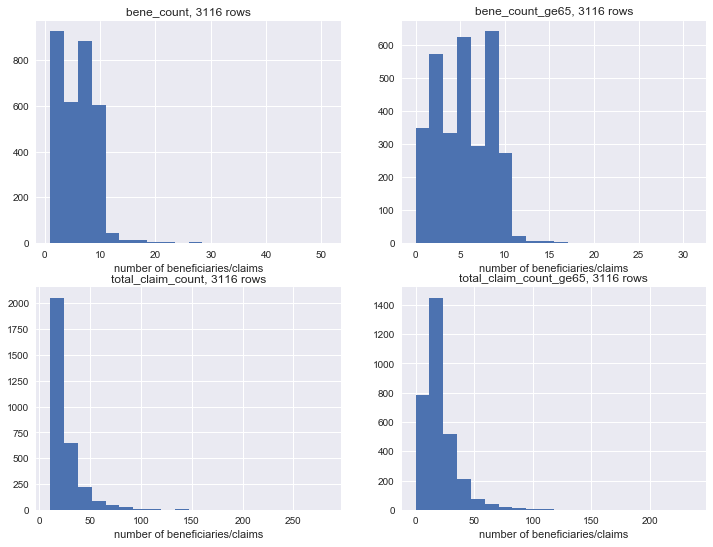

In [72]:
graphs = ['bene_count', 'bene_count_ge65', 'total_claim_count', 'total_claim_count_ge65']

fig = plt.figure(figsize=(12,9))

for i, graph in enumerate(graphs, 1):
    ax = fig.add_subplot(2,2,i)
    ax.hist(imbruvica[graph].dropna(), bins=20)
    count = imbruvica[graph].dropna().count()
    title = '{}, {} rows'.format(graph, count)
    ax.set_title(title)
    ax.set_xlabel('number of beneficiaries/claims')

plt.tight_layout;

In [73]:
#Take columns that do not have false salues to make simple, initial model
# need to make dummies for description_flag
imbruvica_simp_cols = imbruvica.columns[imbruvica.isnull().any() != True]
imbruvica_simp = imbruvica[imbruvica_simp_cols]
drop_cols = ['nppes_provider_last_org_name', 'nppes_provider_first_name', 'nppes_provider_city', 'nppes_provider_state', 'zip', 'specialty_description', 'drug_name', 'generic_name', 'description_flag']
imbruvica_simp.set_index('npi', inplace=True)
imbruvica_simp.drop(drop_cols, axis=1, inplace=True)

/Users/mattheweng/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [74]:
imbruvica_simp.head()

,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,bene_count_ge65,total_claim_count_ge65,total_30_day_fill_count_ge65,total_day_supply_ge65,total_drug_cost_ge65,...,land_sq_mi,zip_density,n_returns,eld_returns,n_return_total_inc,total_income_amt,n_returns_wages,wages_amt,total_income_per_return,total_wages_per_return
npi,,,,,,,,,,,,,,,,,,,,,
1114922432,10.0,11,11.0,330,114210.49,6.0,8.0,2.0,688.740797,221163.300027,...,16.395,2108.081732,15860.0,2330.0,15860.0,625504.0,12740.0,460889.0,0.025356,0.027642
1922086412,10.0,11,11.0,330,110377.54,7.0,11.0,11.0,330.000000,110377.540000,...,16.395,2108.081732,15860.0,2330.0,15860.0,625504.0,12740.0,460889.0,0.025356,0.027642
1104804798,10.0,13,13.0,390,130140.72,5.0,13.0,13.0,390.000000,130140.720000,...,16.395,2108.081732,15860.0,2330.0,15860.0,625504.0,12740.0,460889.0,0.025356,0.027642
1477558880,2.0,43,44.5,1259,335814.15,10.0,43.0,44.5,1259.000000,335814.150000,...,16.395,2108.081732,15860.0,2330.0,15860.0,625504.0,12740.0,460889.0,0.025356,0.027642
1124023452,10.0,26,26.0,780,257178.09,10.0,8.0,1.0,688.740797,221163.300027,...,16.395,2108.081732,15860.0,2330.0,15860.0,625504.0,12740.0,460889.0,0.025356,0.027642


In [75]:
bottom_25_index = imbruvica_simp['total_claim_count'].sort_values()[:779].keys().values
bottom25_3 = imbruvica_simp.loc[bottom_25_index]
top_25_index = imbruvica_simp['total_claim_count'].sort_values()[2337:].keys().values
top25_3 = imbruvica_simp.loc[top_25_index]

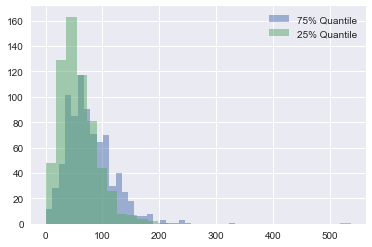

In [76]:
top25 = imbruvica_simp[imbruvica_simp['total_claim_count'] >= imbruvica_simp['total_claim_count'].quantile(0.75)]
bottom25 = imbruvica_simp[imbruvica_simp['total_claim_count'] < imbruvica_simp['total_claim_count'].quantile(0.25)]

top25['beneficiary_male_count'].hist(alpha=0.5, label='75% Quantile', bins=30)
bottom25['beneficiary_male_count'].hist(alpha=0.5, label='25% Quantile', bins=30)
plt.legend();

In [77]:
# top25_index = np.random.choice(imbruvica_simp.index[imbruvica_simp['bene_count'] >= 8.0], 779)
# top25_2 = imbruvica_simp.iloc[top25_index]
# bottom25_index = np.random.choice(imbruvica_simp.index[imbruvica_simp['bene_count'] <= 3.0], 779)
# bottom25_2 = imbruvica_simp.iloc[bottom25_index]

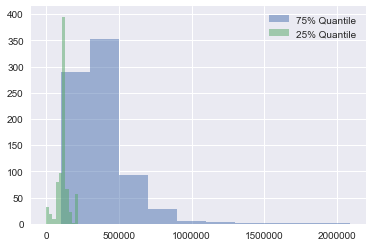

In [78]:
top25_3['total_drug_cost_ge65'].hist(alpha=0.5, label='75% Quantile', bins=10)
bottom25_3['total_drug_cost_ge65'].hist(alpha=0.5, label='25% Quantile', bins=10)
plt.legend();

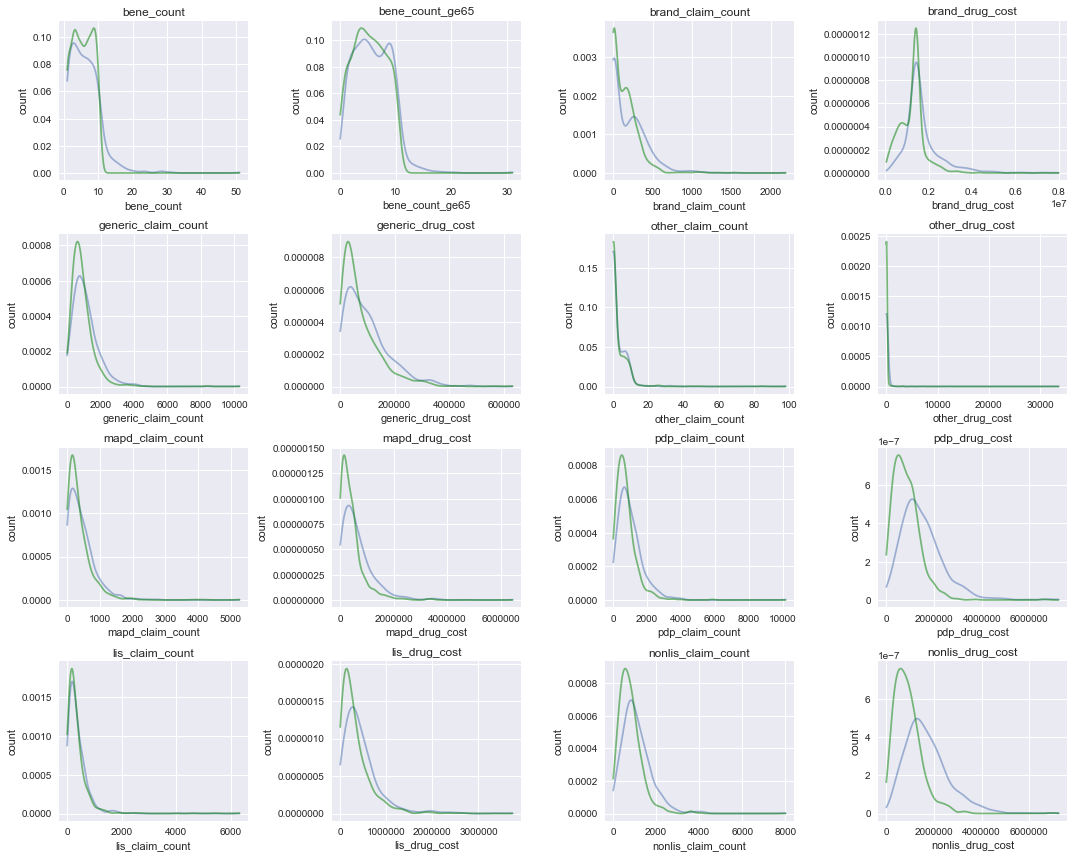

In [79]:
# plot doctor prescribing characteristics
# used total_claim_count for drug as metric
hist1 = top25_3
hist2 = bottom25_3

graphs = ['bene_count', 'bene_count_ge65', 'brand_claim_count', 'brand_drug_cost', 'generic_claim_count', 'generic_drug_cost', 'other_claim_count', 'other_drug_cost', 'mapd_claim_count', 'mapd_drug_cost', 'pdp_claim_count', 'pdp_drug_cost', 'lis_claim_count', 'lis_drug_cost', 'nonlis_claim_count', 'nonlis_drug_cost']

fig = plt.figure(figsize=(15,12))

for i, graph in enumerate(graphs, 1):
    ax = fig.add_subplot(4,4,i)
    max_val = max([hist1[graph].max(), hist2[graph].max()]) # find max of all data, used to make bin sizes same
    min_val = min([hist1[graph].min(), hist2[graph].min()]) # find min of all data, used to make bin sizes same
#     ax.hist(hist1[graph], bins=20, range=(min_val, max_val), alpha=0.5)
#     ax.hist(hist2[graph], bins=20, range=(min_val, max_val), alpha=0.5)
    
    #plot KDE curve
    kde1 = stats.gaussian_kde(hist1[graph])
    kde2 = stats.gaussian_kde(hist2[graph])
    x = np.linspace(min_val, max_val, 1000)
    label1 = '{}'.format(hist1)
    label2 = '{}'.format(hist2)
    ax.plot(x, kde1(x), alpha=0.5, label=label1)
    ax.plot(x, kde2(x), alpha=0.5, label=label2, color='green')
    
    title = '{}'.format(graph)
    ax.set_title(title)
    ax.set_ylabel('count')
    ax.set_xlabel('{}'.format(graph))

plt.tight_layout(pad=1.0);

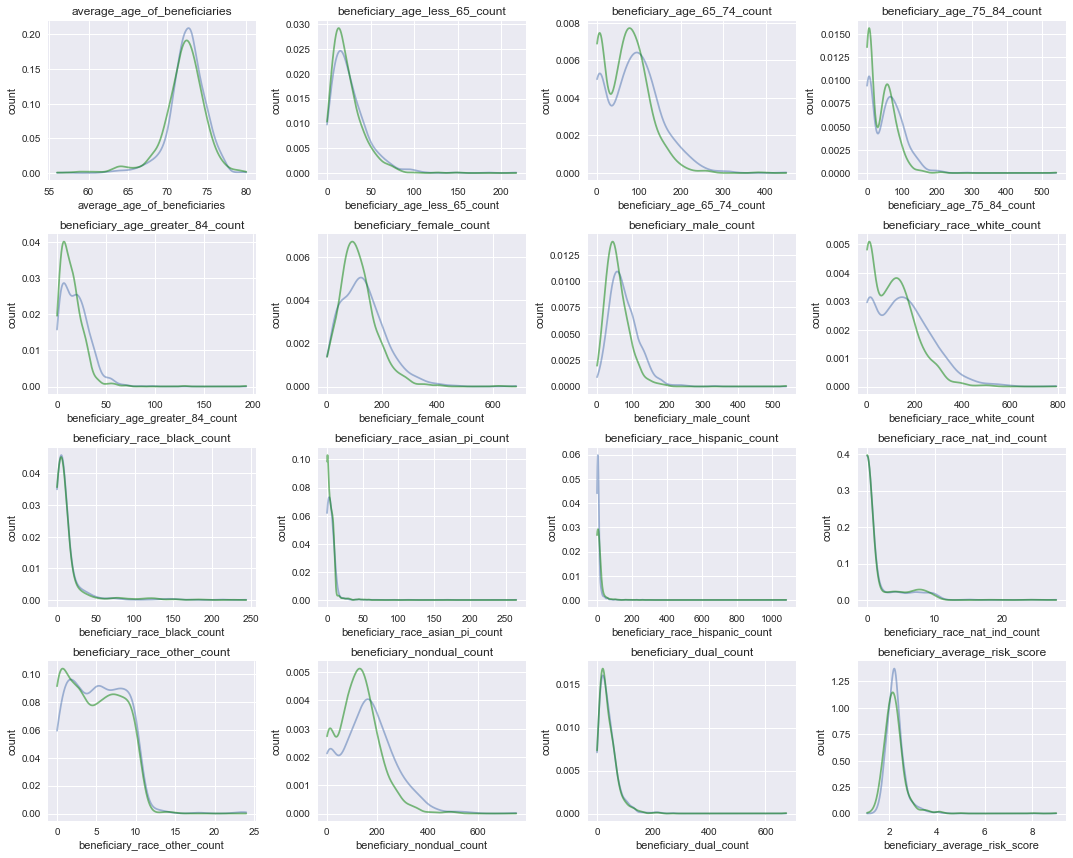

In [80]:
# plot beneficiary characteristics for doctor groups
# used total_claim_count for drug as metric
hist1 = top25_3
hist2 = bottom25_3

graphs = ['average_age_of_beneficiaries', 'beneficiary_age_less_65_count',
       'beneficiary_age_65_74_count', 'beneficiary_age_75_84_count',
       'beneficiary_age_greater_84_count', 'beneficiary_female_count',
       'beneficiary_male_count', 'beneficiary_race_white_count',
       'beneficiary_race_black_count', 'beneficiary_race_asian_pi_count',
       'beneficiary_race_hispanic_count', 'beneficiary_race_nat_ind_count',
       'beneficiary_race_other_count', 'beneficiary_nondual_count',
       'beneficiary_dual_count', 'beneficiary_average_risk_score'
         ]

fig = plt.figure(figsize=(15,12))

for i, graph in enumerate(graphs, 1):
    ax = fig.add_subplot(4,4,i)
    max_val = max([hist1[graph].max(), hist2[graph].max()]) # find max of all data, used to make bin sizes same
    min_val = min([hist1[graph].min(), hist2[graph].min()]) # find min of all data, used to make bin sizes same
#     ax.hist(hist1[graph], bins=20, range=(min_val, max_val), alpha=0.5)
#     ax.hist(hist2[graph], bins=20, range=(min_val, max_val), alpha=0.5)
    
    #plot KDE curve
    kde1 = stats.gaussian_kde(hist1[graph])
    kde2 = stats.gaussian_kde(hist2[graph])
    x = np.linspace(min_val, max_val, 1000)
    label1 = '{}'.format(hist1)
    label2 = '{}'.format(hist2)
    ax.plot(x, kde1(x), alpha=0.5, label=label1)
    ax.plot(x, kde2(x), alpha=0.5, label=label2, color='green')
    
    title = '{}'.format(graph)
    ax.set_title(title)
    ax.set_ylabel('count')
    ax.set_xlabel('{}'.format(graph))

plt.tight_layout(pad=1.0);

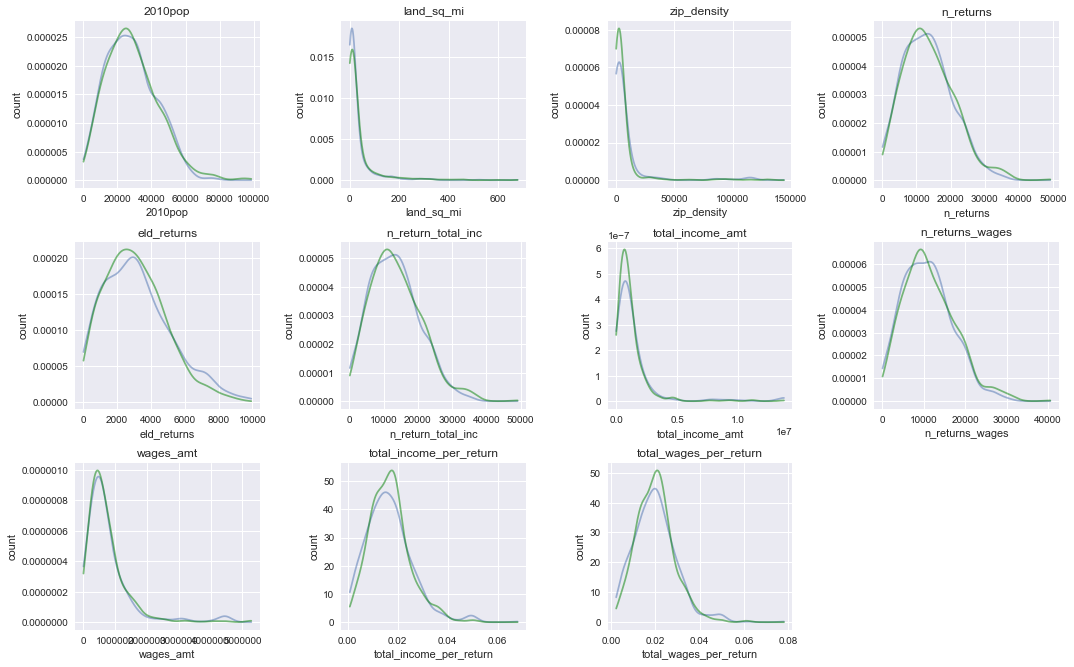

In [81]:
# plot beneficiary zipcode characteristics for doctor groups
# used total_claim_count for drug as metric
hist1 = top25_3
hist2 = bottom25_3

graphs = ['2010pop',
       'land_sq_mi', 'zip_density', 'n_returns', 'eld_returns',
       'n_return_total_inc', 'total_income_amt', 'n_returns_wages',
       'wages_amt', 'total_income_per_return', 'total_wages_per_return'
         ]

fig = plt.figure(figsize=(15,12))

for i, graph in enumerate(graphs, 1):
    ax = fig.add_subplot(4,4,i)
    max_val = max([hist1[graph].max(), hist2[graph].max()]) # find max of all data, used to make bin sizes same
    min_val = min([hist1[graph].min(), hist2[graph].min()]) # find min of all data, used to make bin sizes same
#     ax.hist(hist1[graph], bins=20, range=(min_val, max_val), alpha=0.5, density=True)
#     ax.hist(hist2[graph], bins=20, range=(min_val, max_val), alpha=0.5, density=True)
    
    #plot KDE curve
    kde1 = stats.gaussian_kde(hist1[graph])
    kde2 = stats.gaussian_kde(hist2[graph])
    x = np.linspace(min_val, max_val, 1000)
    ax.plot(x, kde1(x), alpha=0.5)
    ax.plot(x, kde2(x), alpha=0.5, color='green')

    title = '{}'.format(graph)
    ax.set_title(title)
    ax.set_ylabel('count')
    ax.set_xlabel('{}'.format(graph))

plt.tight_layout(pad=1.0);

In [82]:
# Possible to determine the probability of being given a drug earlier rather than later?
# Do these trends decrease over time?

### Modeling

In [240]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

In [282]:
def get_Xy(dataframe, target_col, drop_cols=[], dummy_vars = []):
    
    data = dataframe.copy()
    
    # Get y labels
    labels = data[target_col]
    
    # Create dummy variables
    for col in dummy_vars:
        data = data.join(pd.get_dummies(data[col], drop_first=True))
    
    # Drop columns
    data.drop(drop_cols, axis=1, inplace=True)
    data.drop(target_col, axis=1, inplace=True)
    data.drop(dummy_vars, axis=1, inplace=True)
    
    return data, labels

In [283]:
# Get X and y for regression model

drop_cols = ['bene_count', 'bene_count_ge65',
             'total_drug_cost', 'total_drug_cost_ge65', 'total_claim_count_ge65',
             'total_day_supply_ge65', 'total_30_day_fill_count_ge65',
             'total_30_day_fill_count', 'total_day_supply', 
             'nppes_provider_street1', 'nppes_provider_country',
             'nppes_entity_code']

dummy_vars = ['medicare_prvdr_enroll_status', 'nppes_credentials', 'nppes_provider_gender']

imbruvica_model, labels = get_Xy(imbruvica_simp, 'total_claim_count', drop_cols=drop_cols, dummy_vars=dummy_vars)

#### Linear Regression

In [284]:
lm = LinearRegression()
lm.fit(imbruvica_model, labels)
cross_val_score(lm, imbruvica_model, y=labels).mean()

0.15185656267946315

In [202]:
r2_score()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'normalize': False}

#### Lasso Regression

In [295]:
lassor = Lasso(alpha=140)
cross_val_score(lassor, imbruvica_model, y=labels).mean()

0.17155626508948907

#### Ridge Regression

In [286]:
ridger = Ridge(alpha=10)
cross_val_score(ridger, imbruvica_model, y=labels).mean()

0.15748014682653177

#### GBM


In [296]:
gbr = GradientBoostingRegressor()
gbr.fit(imbruvica_model, labels)
cross_val_score(gbr, imbruvica_model, y=labels).mean()

0.12163270866327258

In [207]:
# parameter search
gbr = GradientBoostingRegressor()

param_grid = {'learning_rate': [0.001, 0.01, 0.1], 
              'n_estimators': [100, 300, 600],
              'max_depth': [None, 3, 6],
              'max_features': [None, 9, 18]
             }

clf = GridSearchCV(gbr, param_grid)
clf.fit(imbruvica_model, labels)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.001, 0.01, 0.1], 'n_estimators': [100, 300, 600], 'max_depth': [None, 3, 6], 'max_features': [None, 9, 18]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [210]:
clf.best_score_

0.16732391818672632

In [211]:
clf.best_params_

{'learning_rate': 0.01,
 'max_depth': 3,
 'max_features': 18,
 'n_estimators': 600}

In [ ]:
# can get average drug cost from total_drug_cost?

In [271]:
# Plot feature importances

def plot_feature_importances(model, data):

    feature_matrix = pd.DataFrame(data=model.feature_importances_.reshape(1,-1), columns=data.columns)

    # Collapse dummy variables
    feature_matrix['medicare_provdr_enroll_status'] = feature_matrix['N'] + feature_matrix['O']
    feature_matrix['nppes_credentials'] = feature_matrix[['MD', 'MD plus', 'NP', 'Other', 'PA', 'PAC', 'RN']].sum(axis=1)
    feature_matrix['nppes_provider_gender'] = feature_matrix['M']

    feature_matrix.drop(['N', 'O', 'MD', 'MD plus', 'NP', 'Other', 'PA', 'PAC', 'RN', 'M'], axis=1, inplace=True)

    feature_matrixT = feature_matrix.T.sort_values(0, ascending=False)
    
    plt.figure(figsize=(12,9))
    plt.barh(feature_matrixT.index[::-1], feature_matrixT[0].values[::-1]);

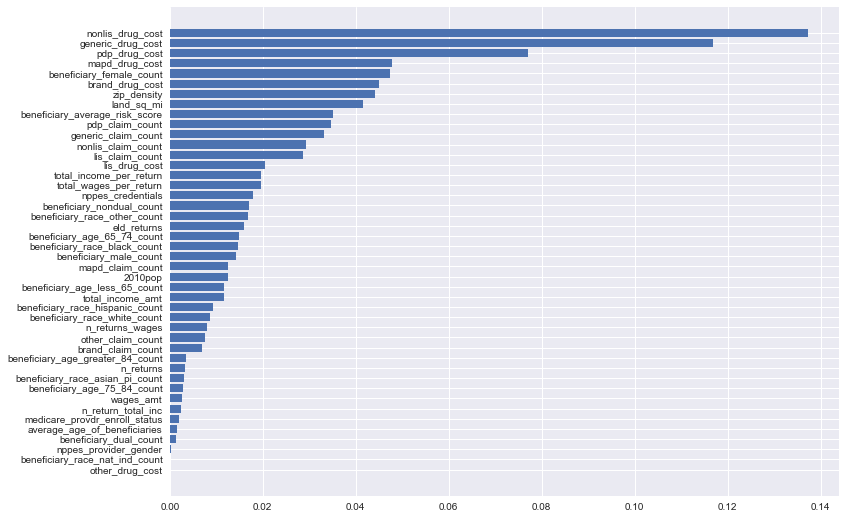

In [277]:
# Plot feature importances for gradient boosting regression model
gbr = GradientBoostingRegressor()
gbr.fit(imbruvica_model, labels)

plot_feature_importances(gbr, imbruvica_model)

 - Linear regression, Lasso, Ridge, and Gradient Boosted Regressors gave poor accuracy scores for the data inputted.

### Change labels to be binary

 - As regressor models did not perform well, I changed labels to be binary. This was performed by using the lower bound of the top 25th percentile of doctors who had the highest total claim counts

In [263]:
## Change label to be binary

labels_top25_bin = pd.DataFrame(imbruvica_simp['total_claim_count'])
labels_top25_bin['total_claim_count_bin'] = 0
labels_top25_bin.loc[labels_top25_bin['total_claim_count'] >= labels_top25_bin['total_claim_count'].quantile(0.75), :] = 1
labels_top25_bin.drop('total_claim_count', axis=1, inplace=True)
labels_top25_bin = labels_top25_bin.values.flatten()

#### Logistic regression with binary labels

In [265]:
logm = LogisticRegression()
#logm.fit(imbruvica_model, labels_top25_bin)
cross_val_score(logm, imbruvica_model, y=labels_top25_bin).mean()

0.75289280055979912

#### Gradient Boosting Classifier with binary labels

In [299]:
gbc = GradientBoostingClassifier()
gbc.fit(imbruvica_model, labels_top25_bin)
cross_val_score(gbc, imbruvica_model, y=labels_top25_bin).mean()

0.74583164114004685

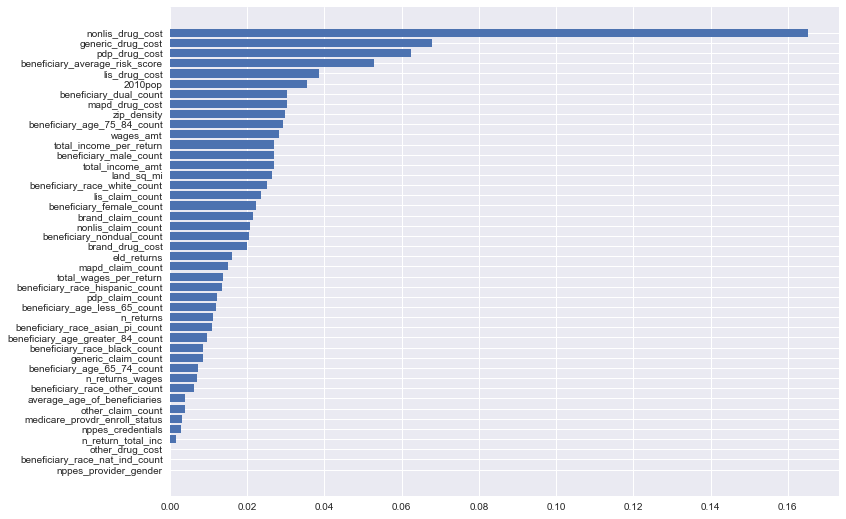

In [278]:
plot_feature_importances(gbc, imbruvica_model)

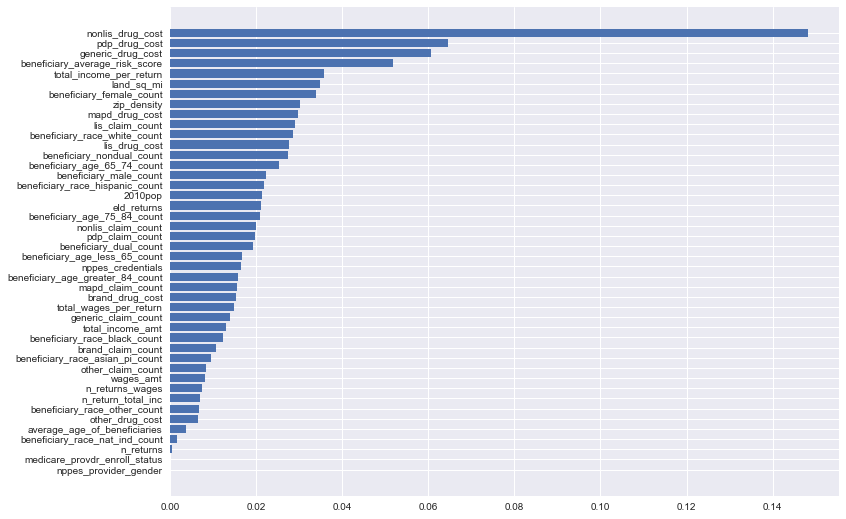

In [303]:
# Split data and plot feature importances multiple times to observe whether top features remain consistent each time
X_train, X_test, y_train, y_test = train_test_split(imbruvica_model, labels_top25_bin)

gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

plot_feature_importances(gbc, X_train)